In [ ]:
"""
Copyright 2022, The Johns Hopkins University Applied Physics Laboratory LLC
All rights reserved.
Distributed under the terms of the BSD 3-Clause License.

Approved for public release; distribution is unlimited.
This material is based upon work supported by the Defense Advanced Research Projects Agency (DARPA) under Agreement No. HR00112290032.
"""

In [1]:
import os
import sys
import pickle
import json
import time
from multiprocessing import Pool
from functools import partial
from itertools import repeat

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from scipy.integrate import odeint
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import torch
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

# from box_model import box_model
if '..' not in sys.path:
	sys.path.append('..')
from gan_mad_clf import GANTrainer
from surrogates.four_box_partial import FourBoxPartialModel
from gan_utils.label_funcs import get_gen_mad_labels, get_disc_mad_labels, get_gen_soft_clf_labels, get_disc_clf_labels, get_disc_clf_labels_three_class
from gan_utils.losses import mad_clf_loss

In [31]:
# Read in model checkpoints and box model data
sim_idx = 1
n_gens = 3
n_classes = 3

save_dir = os.path.join('/home', 'chungdw1', 'PACMANs', 'gan', 'tmp')
# save_subdir = f'box_anand_sim_{sim_idx}_time_{n_classes}c_n{n_gens}'
# save_subdir = f'box_anand_sim_{sim_idx}_{n_classes}c_n{n_gens}'
# save_subdir = f'box_anand_sim_{sim_idx}_n{n_gens}'
save_subdir = f'stoc_four_box_anand_sim_{sim_idx}_{n_classes}c_n{n_gens}'

chkpt_subdir = os.path.join(save_dir, save_subdir, 'chkpts')
load_data_path = f"../tmp/data/anand_sim_{sim_idx}_{n_classes}c.pkl"

# sim_config_file = f"../scripts/anand_sim_configs/sim_{sim_idx}_config.json"
sim_config_file = f"../scripts/anand_sim_configs/sim_{sim_idx}_config_stoc.json"
# sim_config_file = f"../scripts/box_configs/anand_sim_{sim_idx}_box_cfg.json"

In [32]:
# Instantiate GAN trainer
x_size = 3
z_size = 64
device = 0

class_names = []
if n_classes == 2: 
	class_names = ["Non-shutoff", "Shutoff"]
	disc_clf_label_func = get_disc_clf_labels
elif n_classes == 3:
	class_names = ["Non-shutoff", "Shutoff", "Recovery"]
	disc_clf_label_func = get_disc_clf_labels_three_class

# Loss functions
gen_loss_func = mad_clf_loss
disc_loss_func = mad_clf_loss

# Labelling functions
gen_mad_label_func, disc_mad_label_func = get_gen_mad_labels, get_disc_mad_labels
gen_clf_label_func = get_gen_soft_clf_labels

# Read in config file
with open(sim_config_file, "r") as f:
	sim_config = json.load(f)
surrogate_kwargs = {k:v for k,v in sim_config.items() if k != "n_samples"}

# Set up surrogate model
surrogate_model = FourBoxPartialModel(n_jobs=12, **surrogate_kwargs)

save_dir = os.path.join('/home', 'chungdw1', 'PACMANs', 'gan', 'tmp')
chkpt_freq = 10
chkpt_idx = 60
gan_trainer = GANTrainer(n_gens, x_size, class_names, z_size, surrogate_model=surrogate_model,
				gen_loss_func=gen_loss_func, disc_loss_func=disc_loss_func,
				gen_mad_label_func=gen_mad_label_func, disc_mad_label_func=disc_mad_label_func,
				gen_clf_label_func=gen_clf_label_func, disc_clf_label_func=disc_clf_label_func,
				mb_disc_out=128, device=device, save_dir=save_dir, save_subdir=save_subdir, load_data_path=load_data_path,
				chkpt_idx=chkpt_idx, chkpt_freq=chkpt_freq)

# # Load model checkpoints
# print('Loading model checkpoints...')
# chkpt_idx = 40
# # gens_chkpt_path = os.path.join(chkpt_subdir, f'gens_{chkpt_idx}.pt')
# disc_chkpt_path = os.path.join(chkpt_subdir, f'disc_{chkpt_idx}.pt')
# gens_loss_path = os.path.join(chkpt_subdir, f'gens_losses_{chkpt_idx}.pkl')
# disc_loss_path = os.path.join(chkpt_subdir, f'disc_losses_{chkpt_idx}.pkl')

# for i in range(gan_trainer.n_gens):
#     gens_chkpt_path = os.path.join(chkpt_subdir, f'gen_{i}_{chkpt_idx}.pt')
#     gan_trainer.gens[i].load_state_dict(torch.load(gens_chkpt_path, map_location=device))
# gan_trainer.disc.load_state_dict(torch.load(disc_chkpt_path, map_location=device))

# with open(gens_loss_path, 'rb') as f:
#     gens_loss = pickle.load(f)
# with open(disc_loss_path, 'rb') as f:
#     disc_loss = pickle.load(f)

cuda:0
Loading checkpoint 60...
Loading generator checkpoint for epoch 60...
Loading discriminator checkpoint for epoch 60...
Loading training data...
Loading test data...


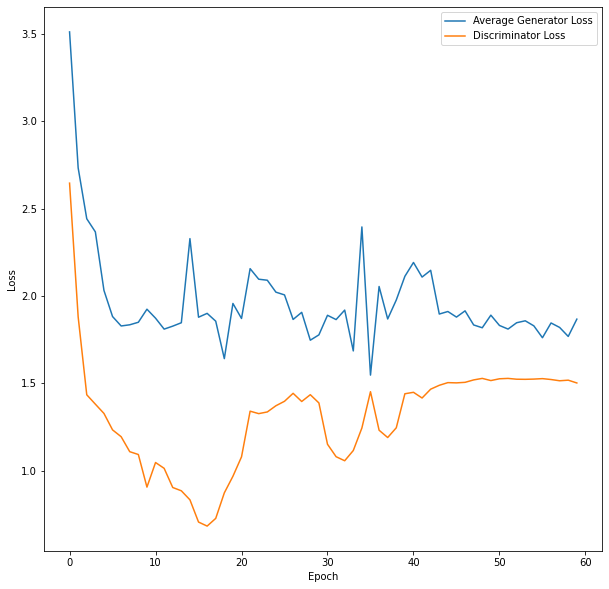

In [33]:
# Plot GAN losses
# Average the generator losses
gens_agg_loss = np.stack([v for v in gan_trainer.gen_losses.values()], axis=0).mean(axis=0)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(gens_agg_loss)
ax.plot(gan_trainer.disc_losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Average Generator Loss', 'Discriminator Loss'])

# Save plot
loss_fig_path = os.path.join(save_dir, save_subdir, f'losses_{chkpt_idx}.jpeg')
plt.savefig(loss_fig_path)

plt.show()

# Plot real data

In [34]:
for i, ln in enumerate(class_names):
	print(f"Label: {ln}")
	print(f"Count: {gan_trainer.real_labels[gan_trainer.real_labels == i].size}/{gan_trainer.real_labels.size}")
	print()

Label: Non-shutoff
Count: 6793/20379

Label: Shutoff
Count: 6793/20379

Label: Recovery
Count: 6793/20379



In [35]:
def plot_solutions(solutions, save_path="test"):
    # fourbox_args = dict(
    #     N=4000, K_v=1e-5, A_GM=1000, M_ek=25e6,
    #     A_Redi=1000, M_SD=15e6, D_low0=400,
    #     T_north0=2, T_south0=4, T_low0=17, T_deep0=3,
    #     S_north0=35, S_south0=36, S_low0=36, S_deep0=34.5,
    #     Fws=1e6, Fwn=0.05e6, epsilon=1.2e-4
    # )
    fig, ax = plt.subplots(figsize=(10,10))
    fig1, ax1 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    fig2, ax2 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    fig3, ax3 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
    for kwargs in solutions:
        # M_n, M_upw, M_eddy, D_low, T, S, sigma0 = box_model(**kwargs)
        # todo: modify to plot solutions from the input
        ax.plot(M_n, color='blue', label='M_n')
        ax.plot(M_upw, color='orange', label='M_upw')
        ax.plot(M_eddy, color='green', label='M_eddy')
        # ax.plot(D_low, color='red', label='Dlow')
        # plt.show()
        # fig, ax = plt.subplots(nrows=2, ncols=2)
        ax1[0, 0].plot(T[0], color='blue', label='T_n')
        ax1[0, 1].plot(T[1], color='orange', label='T_s')
        ax1[1, 0].plot(T[2], color='green', label='T_l')
        ax1[1, 1].plot(T[3], color='red', label='T_d')
        # plt.show()
        # fig1, ax1 = plt.subplots(nrows=2, ncols=2)
        ax2[0, 0].plot(S[0], color='blue', label='S_n')
        ax2[0, 1].plot(S[1], color='orange', label='S_s')
        ax2[1, 0].plot(S[2], color='green', label='S_l')
        ax2[1, 1].plot(S[3], color='red', label='S_d')
        # plt.show()
        # fig2, ax2 = plt.subplots(nrows=2, ncols=2)
        ax3[0, 0].plot(sigma0[0], color='blue', label='sigma0_n')
        ax3[0, 1].plot(sigma0[1], color='orange', label='sigma0_s')
        ax3[1, 0].plot(sigma0[2], color='green', label='sigma0_l')
        ax3[1, 1].plot(sigma0[3], color='red', label='sigma0_d')
        # plt.show()

    # Make legends
    custom_lines = [Line2D([0], [0], color='blue', alpha=1.0),
                    Line2D([0], [0], color='orange', alpha=1.0),
                    Line2D([0], [0], color='green', alpha=1.0)
                    ]
    ax.legend(custom_lines, ['M_n', 'M_upw', 'M_eddy'])

    ax1[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['T_n'])
    ax1[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['T_s'])
    ax1[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['T_l'])
    ax1[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['T_d'])

    ax2[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['S_n'])
    ax2[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['S_s'])
    ax2[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['S_l'])
    ax2[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['S_d'])

    ax3[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['sigma0_n'])
    ax3[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['sigma0_s'])
    ax3[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['sigma0_l'])
    ax3[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['sigma0_d'])

    fig.savefig(save_path+"_M.jpeg")
    fig1.savefig(save_path+"_T.jpeg")
    fig2.savefig(save_path+"_S.jpeg")
    fig3.savefig(save_path+"_sigma0.jpeg")
    plt.show()

In [7]:
# Get real solutions
# todo: for stochastic four-box, we should be running box model multiple times per config -> aggregate the predicted states (majority or average logits?)
real_solutions = surrogate_model(gan_trainer.test_dataset)

# Get real labels
real_labels = gan_trainer.disc_label_funcs["clf"](real_solutions)

In [8]:
# Get real shutoffs and nonshutoffs
real_shutoff_configs = []
real_shutoff_solutions = []
real_non_shutoff_configs = []
real_non_shutoff_solutions = []
real_recovery_configs = []
real_recovery_solutions = []
for r_sol, r_cfg, r_lbl in zip(real_solutions[0], gan_trainer.test_dataset, real_labels):
	# Get length of solution
	if r_lbl == 1.0:
		real_shutoff_configs.append(r_cfg)
		real_shutoff_solutions.append(r_sol)
	elif r_lbl == 0:
		real_non_shutoff_configs.append(r_cfg)
		real_non_shutoff_solutions.append(r_sol)
	else:
		real_recovery_configs.append(r_cfg)
		real_recovery_solutions.append(r_sol)

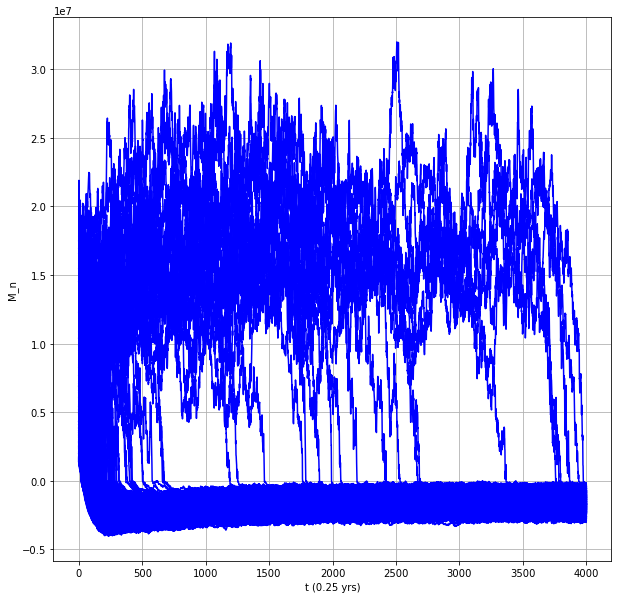

In [9]:
# Plot shutoffs
fig, ax = plt.subplots(figsize=(10,10))
for M_n in real_shutoff_solutions:
	# Strip NaNs
	M_n = M_n[~np.isnan(M_n)]
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
ax.grid()

box_plot_filename = os.path.join(save_dir, save_subdir, "real_shutoff.jpeg")
plt.savefig(box_plot_filename)

In [ ]:
# box_plot_filename = os.path.join(save_dir, save_subdir, "real_shutoff")
# plot_configs(real_shutoff_configs, box_plot_filename)

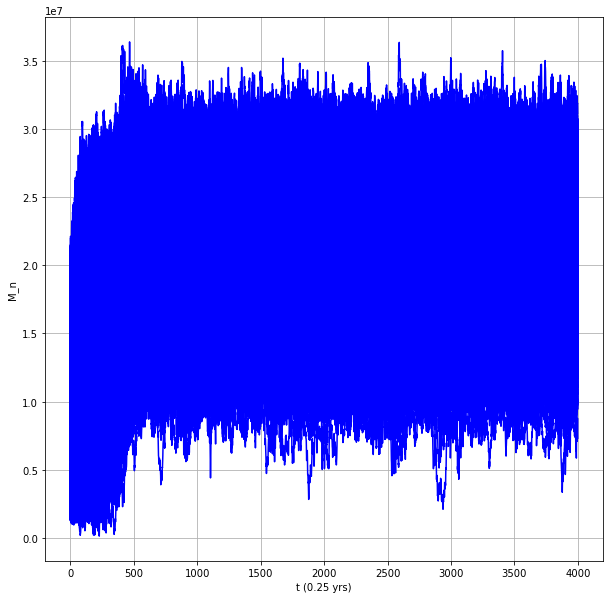

In [10]:
# Plot non-shutoffs
fig, ax = plt.subplots(figsize=(10,10))
for M_n in real_non_shutoff_solutions:
	M_n = M_n[~np.isnan(M_n)]
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
ax.grid()

box_plot_filename = os.path.join(save_dir, save_subdir, "real_nonshutoff.jpeg")
plt.savefig(box_plot_filename)

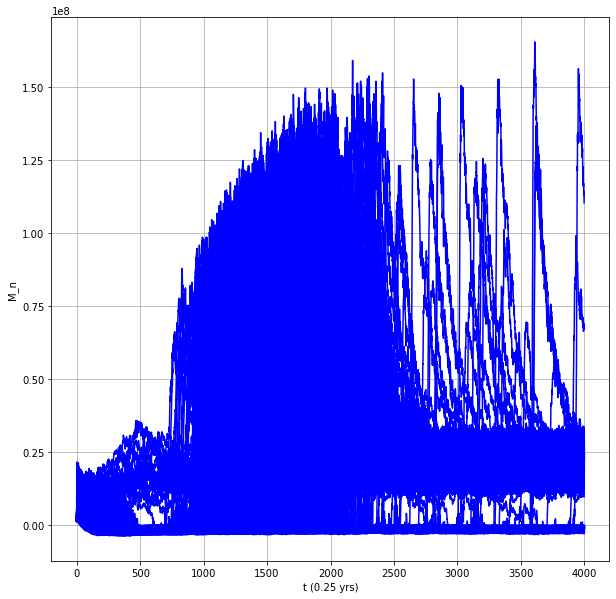

In [11]:
# Plot recoveries
fig, ax = plt.subplots(figsize=(10,10))
for M_n in real_recovery_solutions:
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
ax.grid()

box_plot_filename = os.path.join(save_dir, save_subdir, "real_recovery.jpeg")
plt.savefig(box_plot_filename)

# Bifurcation Plot

In [12]:
# Get Fwn idx from surrogate model
Fwn_idx = surrogate_model.perturb_vars.index("Fwn")
surrogate_model.perturb_vars

['M_ek', 'D_low0', 'Fwn']

In [14]:
# Sort samples by Fwn (northern freshwater flux)
data_samples_sort_idx = np.argsort(gan_trainer.test_dataset[:, Fwn_idx])
data_samples_sorted = gan_trainer.test_dataset[data_samples_sort_idx]

Fwn = data_samples_sorted[:, Fwn_idx]
M_n = real_solutions[0][data_samples_sort_idx][:, -1]

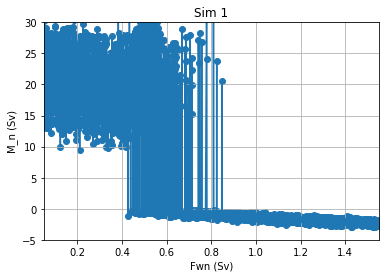

In [15]:
# Plot bifurcation
plt.scatter(Fwn/1e6, M_n/1e6)
plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
plt.title(f"Sim {sim_idx}")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
plt.grid()

save_fig_path = os.path.join(save_dir, save_subdir, f'real_bifur_anand_sim{sim_idx}.jpeg')
plt.savefig(save_fig_path)

In [ ]:
# box_plot_filename = os.path.join(save_dir, save_subdir, "real_non_shutoff")
# plot_configs(real_shutoff_configs, box_plot_filename)

# Generate configurations

In [36]:
# Sample from Generator

print('Generating seeds...')
seeds_per_gen = gan_trainer.test_dataset.shape[0] // n_gens
x_seeds = []
with torch.inference_mode():
	for i in range(gan_trainer.n_gens):
		z_samples = torch.rand(seeds_per_gen, gan_trainer.z_size).uniform_(-1.0, 1.0).double().to(gan_trainer.device)
		gan_trainer.gens[i].eval()
		x_i = gan_trainer.gens[i](z_samples).cpu().reshape(z_samples.shape[0], -1)
		# print(x_i.min(), x_i.max())

		# Re-scale parameters
		x_i_inv = gan_trainer.ic_param_scaler.inverse_transform(x_i)
		# print(x_i_inv.min(), x_i_inv.max())
		x_seeds.append(x_i_inv)
		# break

# Run configs through box model, label solutions
gen_shutoff_cfgs = []
gen_non_shutoff_cfgs = []
gen_recovery_cfgs = []
gen_shutoff_solutions = []
gen_non_shutoff_solutions = []
gen_recovery_solutions = []

gen_clf_labels = []
start_t = time.time()
for i in range(gan_trainer.n_gens):
	print(f"Gen {i}...")
	# Get solutions
	gen_solutions = surrogate_model(x_seeds[i])

	# Get labels
	g_cfg_labels = gan_trainer.disc_label_funcs["clf"](gen_solutions)
	for j, g_cfg_label in enumerate(g_cfg_labels):

		# Get configs and solutions
		g_cfg = x_seeds[i][j]
		g_sol = [gs[j] for gs in gen_solutions]

		if g_cfg_label == 1.0:
			gen_shutoff_solutions.append(g_sol)
			gen_shutoff_cfgs.append(g_cfg)
		elif g_cfg_label == 0:
			gen_non_shutoff_solutions.append(g_sol)
			gen_non_shutoff_cfgs.append(g_cfg)
		else:
			gen_recovery_solutions.append(g_sol)
			gen_recovery_cfgs.append(g_cfg)
		gen_clf_labels.append(g_cfg_label)
	print()
end_t = time.time()
print("Total time (min): ", (end_t - start_t)/60.)

Generating seeds...
Gen 0...

Gen 1...

Gen 2...

Total time (min):  7.652257434527079


In [ ]:
# def plot_solutions(solutions, save_path="test"):
#     # fourbox_args = dict(
#     #     N=4000, K_v=1e-5, A_GM=1000, M_ek=25e6,
#     #     A_Redi=1000, M_SD=15e6, D_low0=400,
#     #     T_north0=2, T_south0=4, T_low0=17, T_deep0=3,
#     #     S_north0=35, S_south0=36, S_low0=36, S_deep0=34.5,
#     #     Fws=1e6, Fwn=0.05e6, epsilon=1.2e-4
#     # )
#     fig, ax = plt.subplots(figsize=(10,10))
#     fig1, ax1 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
#     fig2, ax2 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)
#     fig3, ax3 = plt.subplots(figsize=(10,10), nrows=2, ncols=2)

#     for M_n, M_upw, M_eddy, D_low, T, S, sigma0 in solutions:
#         ax.plot(M_n, color='blue', label='M_n')
#         ax.plot(M_upw, color='orange', label='M_upw')
#         ax.plot(M_eddy, color='green', label='M_eddy')
#         # ax.plot(D_low, color='red', label='Dlow')
#         # plt.show()
#         # fig, ax = plt.subplots(nrows=2, ncols=2)
#         ax1[0, 0].plot(T[0], color='blue', label='T_n')
#         ax1[0, 1].plot(T[1], color='orange', label='T_s')
#         ax1[1, 0].plot(T[2], color='green', label='T_l')
#         ax1[1, 1].plot(T[3], color='red', label='T_d')
#         # plt.show()
#         # fig1, ax1 = plt.subplots(nrows=2, ncols=2)
#         ax2[0, 0].plot(S[0], color='blue', label='S_n')
#         ax2[0, 1].plot(S[1], color='orange', label='S_s')
#         ax2[1, 0].plot(S[2], color='green', label='S_l')
#         ax2[1, 1].plot(S[3], color='red', label='S_d')
#         # plt.show()
#         # fig2, ax2 = plt.subplots(nrows=2, ncols=2)
#         ax3[0, 0].plot(sigma0[0], color='blue', label='sigma0_n')
#         ax3[0, 1].plot(sigma0[1], color='orange', label='sigma0_s')
#         ax3[1, 0].plot(sigma0[2], color='green', label='sigma0_l')
#         ax3[1, 1].plot(sigma0[3], color='red', label='sigma0_d')
#         # plt.show()

#     # Set axes labels
#     ax.set_xlabel("Box model time (0.25 yr)")
#     ax.set_ylabel("Flux (m^3/s)")
#     ax.set_ylim([-.15e8, 1.4e8])
#     # Make legends
#     custom_lines = [Line2D([0], [0], color='blue', alpha=1.0),
#                     Line2D([0], [0], color='orange', alpha=1.0),
#                     Line2D([0], [0], color='green', alpha=1.0),
#                     ]
#     ax.legend(custom_lines, ['M_n', 'M_upw', 'M_eddy'])

#     ax1[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['T_n'])
#     ax1[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['T_s'])
#     ax1[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['T_l'])
#     ax1[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['T_d'])

#     ax2[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['S_n'])
#     ax2[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['S_s'])
#     ax2[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['S_l'])
#     ax2[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['S_d'])

#     ax3[0, 0].legend([Line2D([0], [0], color='blue', alpha=1.0)], ['sigma0_n'])
#     ax3[0, 1].legend([Line2D([0], [0], color='orange', alpha=1.0)], ['sigma0_s'])
#     ax3[1, 0].legend([Line2D([0], [0], color='green', alpha=1.0)], ['sigma0_l'])
#     ax3[1, 1].legend([Line2D([0], [0], color='red', alpha=1.0)], ['sigma0_d'])

#     fig.savefig(save_path+"_M.jpeg")
#     fig1.savefig(save_path+"_T.jpeg")
#     fig2.savefig(save_path+"_S.jpeg")
#     fig3.savefig(save_path+"_sigma0.jpeg")
#     plt.show()

In [37]:
print(f"Number of generated shutoffs: {len(gen_shutoff_solutions)}/{seeds_per_gen*gan_trainer.n_gens}")
print(f"Number of generated non-shutoffs: {len(gen_non_shutoff_solutions)}/{seeds_per_gen*gan_trainer.n_gens}")
print(f"Number of generated recoveries: {len(gen_recovery_solutions)}/{seeds_per_gen*gan_trainer.n_gens}")

Number of generated shutoffs: 721/4074
Number of generated non-shutoffs: 1049/4074
Number of generated recoveries: 2304/4074


In [38]:
gen_shutoff_Mn = []
gen_non_shutoff_Mn = []
gen_recovery_Mn = []
for gs in gen_shutoff_solutions:
	if gs[0].shape[0] == 7999:
		gs[0] = np.insert(gs[0], 0, np.nan, axis=0)
	gen_shutoff_Mn.append(gs[0])

for gs in gen_non_shutoff_solutions:
	if gs[0].shape[0] == 7999:
		gs[0] = np.insert(gs[0], 0, np.nan, axis=0)
	gen_non_shutoff_Mn.append(gs[0])

for gs in gen_recovery_solutions:
	if gs[0].shape[0] == 7999:
		gs[0] = np.insert(gs[0], 0, np.nan, axis=0)
	gen_recovery_Mn.append(gs[0])

gen_shutoff_Mn = np.stack(gen_shutoff_Mn, axis=0)
gen_non_shutoff_Mn = np.stack(gen_non_shutoff_Mn, axis=0)
gen_recovery_Mn = np.stack(gen_recovery_Mn, axis=0)

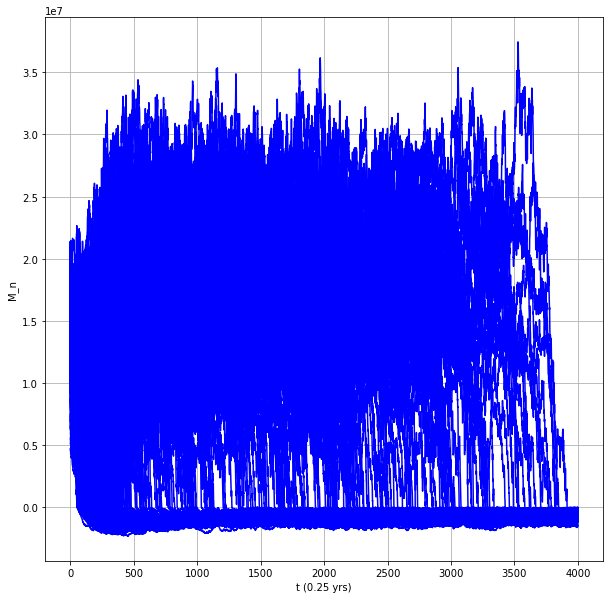

In [39]:
# Plot shutoffs
fig, ax = plt.subplots(figsize=(10,10))
for M_n in gen_shutoff_Mn:
	M_n = M_n[~np.isnan(M_n)]
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
# ax.set_ylim([-0.5e8, 6e8])
ax.grid()

save_fig_path = os.path.join(save_dir, save_subdir, f'gen_Mn_shutoff_chkpt{chkpt_idx}.jpeg')
plt.savefig(save_fig_path)

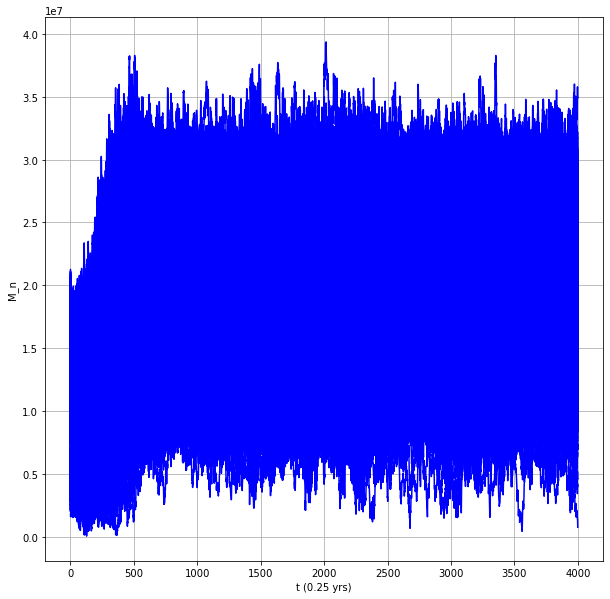

In [40]:
# Plot nonshutoffs
fig, ax = plt.subplots(figsize=(10,10))
for M_n in gen_non_shutoff_Mn:
	M_n = M_n[~np.isnan(M_n)]
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
# ax.set_ylim([-0.5e8, 6e8])
ax.grid()

save_fig_path = os.path.join(save_dir, save_subdir, f'gen_Mn_nonshutoff_chkpt{chkpt_idx}.jpeg')
plt.savefig(save_fig_path)

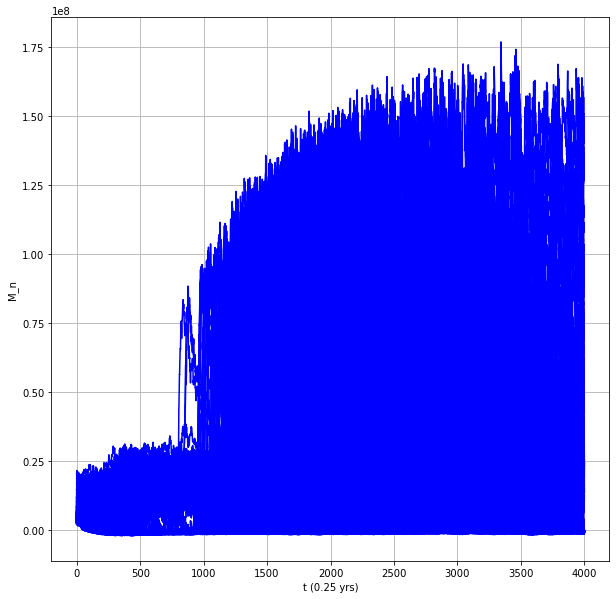

In [41]:
# Plot recoveries
fig, ax = plt.subplots(figsize=(10,10))
for M_n in gen_recovery_Mn:
	ax.plot(M_n, color='blue', label='M_n')
ax.set_xlabel("t (0.25 yrs)")
ax.set_ylabel("M_n")
ax.grid()

save_fig_path = os.path.join(save_dir, save_subdir, f'gen_Mn_recovery_chkpt{chkpt_idx}.jpeg')
plt.savefig(save_fig_path)

# Bifurcation Plot

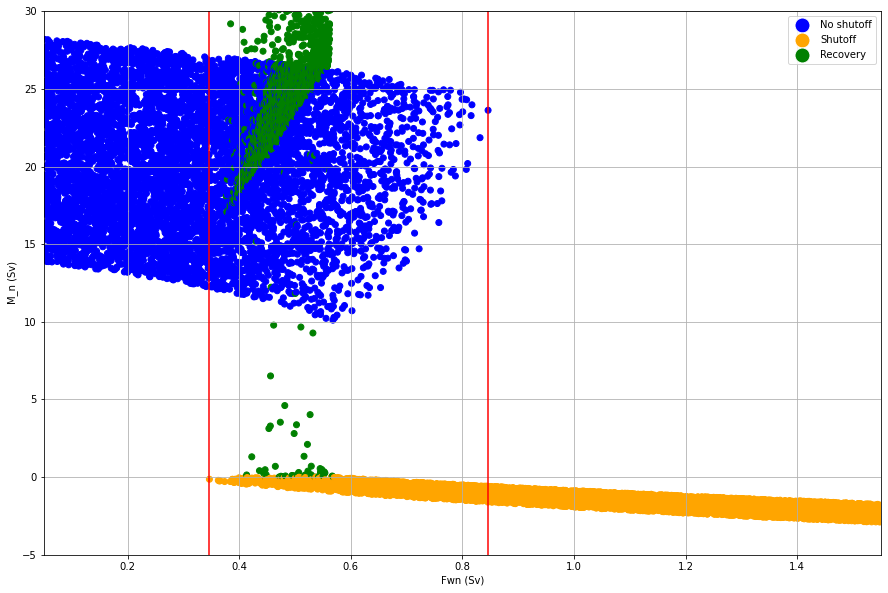

Lower bound: 0.347 (Sv)
Upper bound: 0.847 (Sv)


In [42]:
# Get transient region
def get_transient_region(data_dict, sim_config, n_labels=2):
	# Uncertainty region is defined by Fwn
	Fwn_idx = sim_config["perturb_vars"].index("Fwn")

	# Sort samples by Fwn (northern freshwater flux)
	data_samples = data_dict["sample"]
	data_samples_sort_idx = np.argsort(data_samples[:, Fwn_idx])
	data_samples_sorted = data_samples[data_samples_sort_idx]

	Fwn = data_samples_sorted[:, Fwn_idx]
	M_n = data_dict["last_M_n"][data_samples_sort_idx]
	labels = data_dict["labels"][data_samples_sort_idx]

	# Get sign changes
	M_n_signs = np.sign(M_n)

	# Assume bi-furcation is where AMOC flux reverses first, and AMOC lux recovers last
	first_neg_idx = int(np.argwhere(M_n_signs < 0)[0])
	last_pos_idx = int(np.argwhere(M_n_signs > 0)[-1])

	plot_transient_region(Fwn, M_n, labels, (first_neg_idx, last_pos_idx), n_labels=n_labels)

	return (Fwn[first_neg_idx], Fwn[last_pos_idx+1])

def plot_transient_region(Fwn, M_n, labels, transient_region, n_labels=2):
	plt.figure(figsize=(15, 10))
	if n_labels == 2:
		colors = ["blue", "orange"]
		label_names = ["No shutoff", "Shutoff"]
	elif n_labels == 3:
		colors = ["blue", "orange", "green"]
		label_names = ["No shutoff", "Shutoff", "Recovery"]

	# Plot bifurcation
	plt.scatter(Fwn/1e6, M_n/1e6, c = [colors[l] for l in labels])

	# Plot uncertainty region
	plt.vlines([*[Fwn[bound]/1e6 for bound in transient_region]], ymin=-5.0, ymax=30.0, color="red")
	# plt.plot(Fwn/1e6, M_n/1e6)
	plt.xlabel("Fwn (Sv)")
	plt.ylabel("M_n (Sv)")
	# plt.title(f"Sim {sim_idx}")
	plt.xlim([0.05, 0.05*31])
	plt.ylim([-5.0, 30.0])


	custom_lines = [Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=15, label=l) for c,l in zip(colors, label_names)]
	plt.legend(custom_lines, label_names)
	plt.grid()

	fig_path = os.path.join(save_dir, save_subdir, f'real_bifur_anand_sim{sim_idx}.jpeg')
	plt.savefig(fig_path)

	plt.show()

# Load real data
with open(load_data_path, "rb") as f:
	data_dict = pickle.load(f)

# Get transient region
with open(sim_config_file, "r") as f:
	sim_config = json.load(f)

transient_region = get_transient_region(data_dict, sim_config, n_labels=n_classes)
print(f"Lower bound: {transient_region[0]/1e6:.3f} (Sv)")
print(f"Upper bound: {transient_region[1]/1e6:.3f} (Sv)")

In [43]:
# Get Fwn idx from surrogate model
Fwn_idx = surrogate_model.perturb_vars.index("Fwn")
surrogate_model.perturb_vars

['M_ek', 'D_low0', 'Fwn']

In [24]:
# Aggregate configs and solutions
if n_classes == 2:
	gen_cfgs = np.stack(gen_shutoff_cfgs + \
		gen_non_shutoff_cfgs, axis=0)
	gen_solutions = np.concatenate((gen_shutoff_Mn,
		gen_non_shutoff_Mn), axis=0)
elif n_classes == 3:
	gen_cfgs = np.stack(gen_shutoff_cfgs + \
		gen_non_shutoff_cfgs + \
		gen_recovery_cfgs, axis=0)
	gen_solutions = np.concatenate((gen_shutoff_Mn,
		gen_non_shutoff_Mn,
		gen_recovery_Mn), axis=0)
gen_cfgs.shape, gen_solutions.shape

((4076, 3), (4076, 4000))

In [47]:
# Get logits for the configs
def evaluate_configs(gan_trainer, cfgs, b_sz=128):
	# Set discriminator in evaluation mode
	gan_trainer.disc.eval()
	i = 0
	b_sz = 128
	mad_logits, clf_logits = [], []
	with torch.inference_mode():
		while i < cfgs.shape[0]:
			x_norm = cfgs[i:i+b_sz].to(gan_trainer.device)
			# x_clf_logits = gan_trainer.disc(x_norm)
			x_mad_logits, x_clf_logits = gan_trainer.disc(x_norm)
			mad_logits.append(x_mad_logits)
			clf_logits.append(x_clf_logits)

			i += b_sz

	mad_logits = torch.cat(mad_logits, dim=0)
	clf_logits = torch.cat(clf_logits, dim=0)

	# return clf_logits
	return mad_logits, clf_logits

gen_cfgs_scaled = gan_trainer.ic_param_scaler.transform(gen_cfgs)
# gen_cfgs_scaled = gan_trainer.ic_param_scaler.transform(gan_trainer.test_dataset)
with torch.inference_mode():
	gen_cfg_mad_logits, gen_cfg_clf_logits = evaluate_configs(gan_trainer, torch.Tensor(gen_cfgs_scaled).double(), b_sz=128)
gen_cfg_mad_logits = gen_cfg_mad_logits.cpu()
gen_cfg_clf_logits = gen_cfg_clf_logits.cpu()

# Apply softmax to logits
gen_cfg_clf_probs = torch.nn.functional.softmax(gen_cfg_clf_logits, dim=1).numpy()

# Convert logits to binary labels
if n_classes == 2:
	pos_ref_idx = [1]
elif n_classes == 3:
	pos_ref_idx = [0, 1]
pos_class_probs = gen_cfg_clf_probs[:, pos_ref_idx].sum(axis=1)
neg_class_probs = gen_cfg_clf_probs[:, [i for i in range(n_classes) if i != pos_ref_idx]].sum(axis=1).reshape(-1, 1)
# gen_cfg_clf_probs = np.concatenate((neg_class_probs, pos_class_probs), axis=1)



In [45]:
# Sort samples by Fwn (northern freshwater flux)
data_samples_sort_idx = np.argsort(gan_trainer.test_dataset[:, Fwn_idx])
data_samples_sorted = gan_trainer.test_dataset[data_samples_sort_idx]
data_probs_sorted = pos_class_probs[data_samples_sort_idx]

Fwn = data_samples_sorted[:, Fwn_idx]
M_n = real_solutions[0][data_samples_sort_idx][:, -1]

In [48]:
# Sort samples by Fwn (northern freshwater flux)
data_samples_sort_idx = np.argsort(gen_cfgs[:, Fwn_idx])
data_samples_sorted = gen_cfgs[data_samples_sort_idx]
data_probs_sorted = pos_class_probs[data_samples_sort_idx]

Fwn = data_samples_sorted[:, Fwn_idx]
M_n = gen_solutions[data_samples_sort_idx][:, -1]

TypeError: only integer scalar arrays can be converted to a scalar index

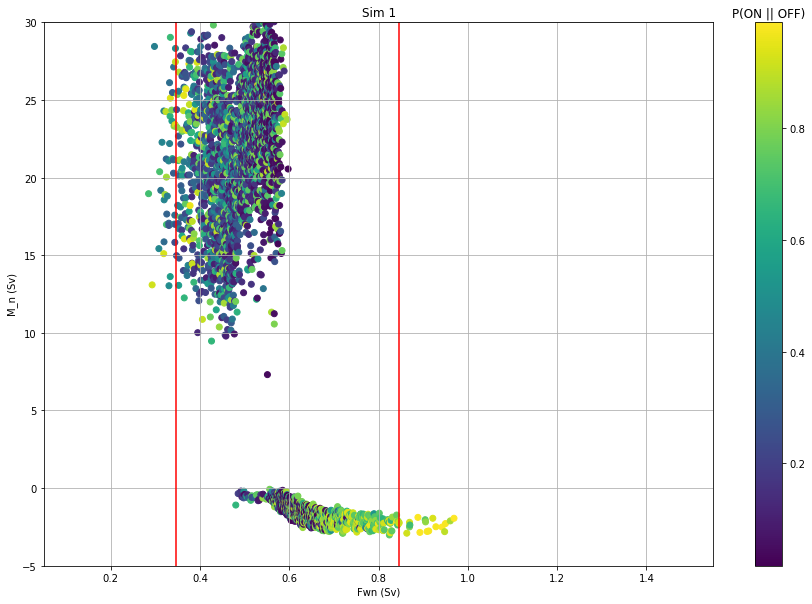

In [49]:
# Plot bifurcation
plt.figure(figsize=(15,10))
plt.scatter(Fwn/1e6, M_n/1e6, c=data_probs_sorted)
# plt.plot(Fwn/1e6, M_n/1e6)
plt.xlabel("Fwn (Sv)")
plt.ylabel("M_n (Sv)")
plt.title(f"Sim {sim_idx}")
plt.xlim([0.05, 0.05*31])
plt.ylim([-5.0, 30.0])
clb = plt.colorbar()
clb.ax.set_title("P(ON || OFF)")
plt.grid()

# Plot uncertainty region
plt.vlines([*[bound/1e6 for bound in transient_region]], ymin=-5.0, ymax=30.0, color="red")

save_fig_path = os.path.join(save_dir, save_subdir, f'gen_bifur_anand_sim{sim_idx}_{n_classes}c_chkpt{chkpt_idx}.jpeg')
plt.savefig(save_fig_path)

In [64]:
# Get test set within transient region
transient_test_idxs = np.argwhere((gan_trainer.test_dataset[:, Fwn_idx] >= transient_region[0]) & \
	(gan_trainer.test_dataset[:, Fwn_idx] <= transient_region[1])).flatten()
transient_test_dataset = gan_trainer.test_dataset[transient_test_idxs]
# transient_test_labels = gan_trainer.test_labels[transient_test_idxs]
transient_test_labels = real_labels[transient_test_idxs]

# Make transient test set predictions
transient_test_scaled = gan_trainer.ic_param_scaler.transform(transient_test_dataset)
with torch.inference_mode():
	transient_test_mad_logits, transient_test_clf_logits = evaluate_configs(gan_trainer, torch.Tensor(transient_test_scaled).double(), b_sz=128)
transient_test_clf_preds = torch.argmax(transient_test_clf_logits, axis=1).cpu()
transient_test_mad_logits = gen_cfg_mad_logits.cpu()
transient_test_clf_logits = gen_cfg_clf_logits.cpu()

# Metrics
transient_test_clf_prec = precision_score(transient_test_labels, transient_test_clf_preds, average=None)
transient_test_clf_recall = recall_score(transient_test_labels, transient_test_clf_preds, average=None)
transient_test_clf_f1 = f1_score(transient_test_labels, transient_test_clf_preds, average=None)

for i,cn in enumerate(class_names):
	print(f"CLASS: {cn}")
	print(f"{cn} examples: {(transient_test_labels == i).sum()}")
	print(f"Clf precision: {transient_test_clf_prec[i]:.3f}",)
	print(f"Clf recall: {transient_test_clf_recall[i]:.3f}")
	print(f"Clf F1: {transient_test_clf_f1[i]:.3f}")
	print()


CLASS: Non-shutoff
Non-shutoff examples: 859
Clf precision: 0.871
Clf recall: 0.489
Clf F1: 0.626

CLASS: Shutoff
Shutoff examples: 234
Clf precision: 0.725
Clf recall: 0.530
Clf F1: 0.612

CLASS: Recovery
Recovery examples: 1197
Clf precision: 0.673
Clf recall: 0.920
Clf F1: 0.777



In [ ]:
# box_plot_filename = os.path.join(save_dir, save_subdir, "gen_non_shutoffs")
# plot_solutions(gen_non_shutoff_solutions, box_plot_filename)

In [ ]:
# box_plot_filename = os.path.join(save_dir, save_subdir, "gen_shutoffs")
# plot_solutions(gen_shutoff_solutions, box_plot_filename)

# Histograms

## Real

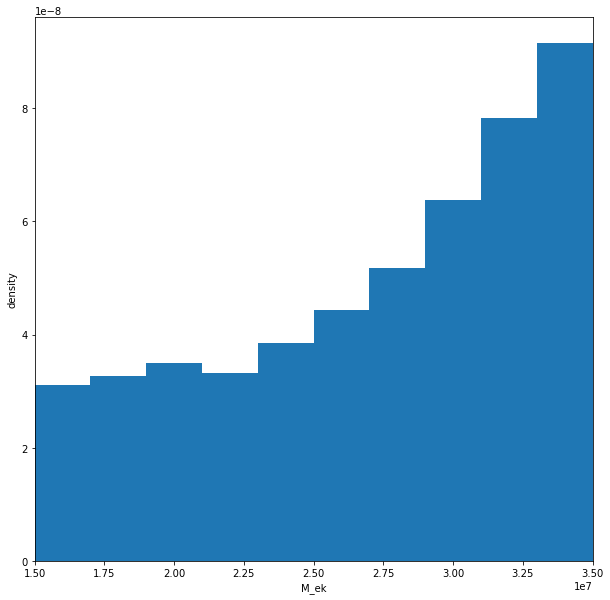

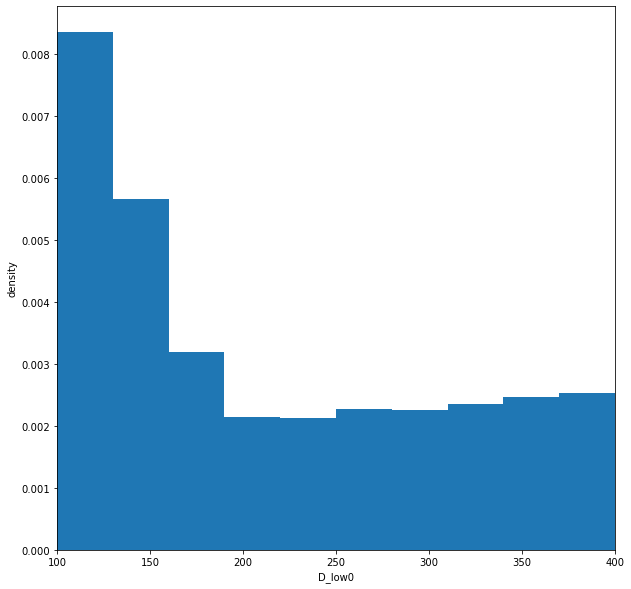

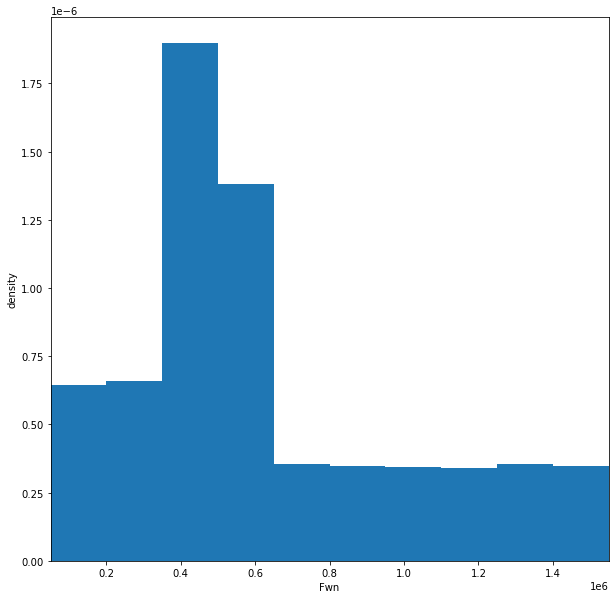

In [65]:
# Plot distribution of real data
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'real_configs_{f_var}_hist.jpeg')
    ax.hist(gan_trainer.real_dataset[:, f_idx], density=True)
    ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_xlabel(f_var)
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

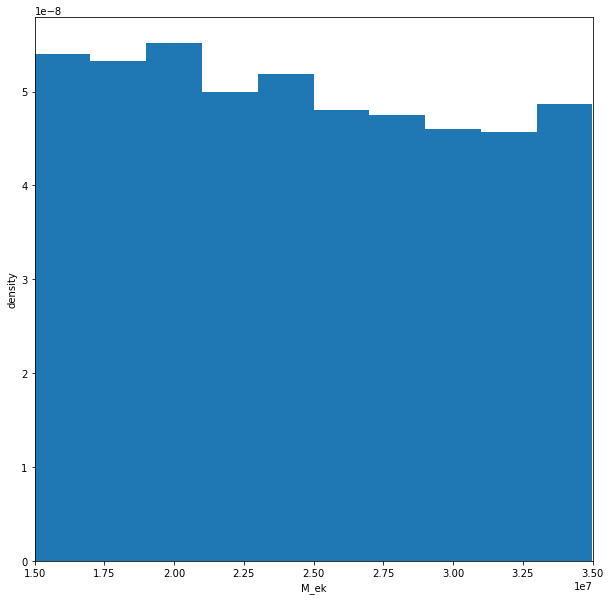

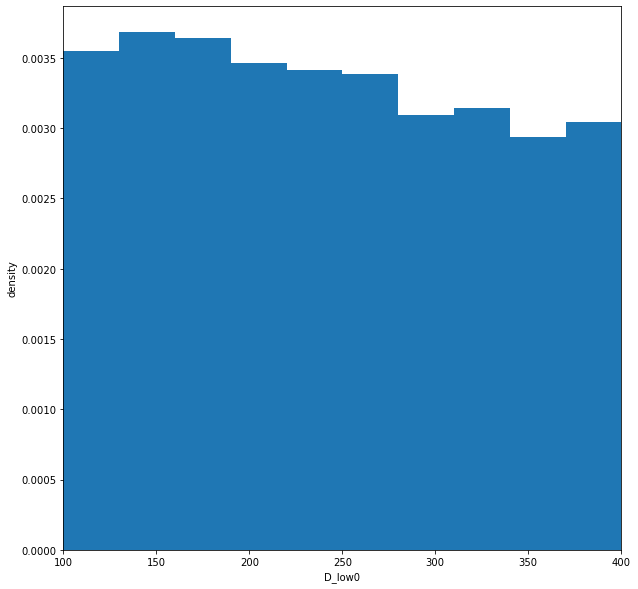

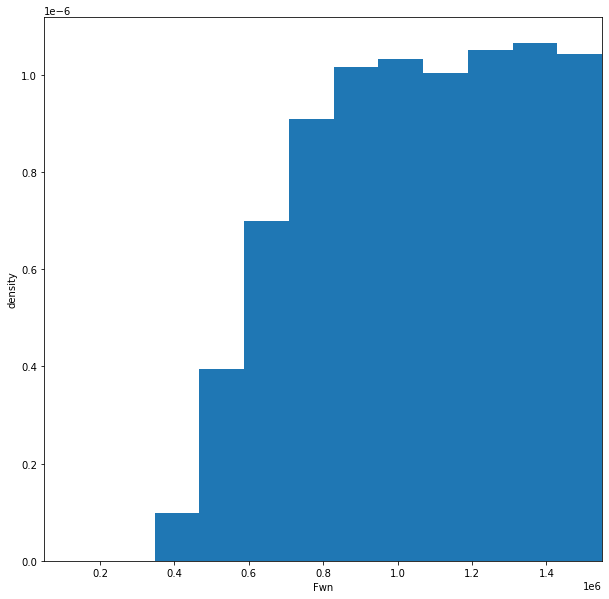

In [66]:
# Plot real shutoffs
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

real_shutoff_idxs = np.where(gan_trainer.real_labels == 1)[0]
x_seeds_agg = gan_trainer.real_dataset[real_shutoff_idxs, :]

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'real_shutoffs_{f_var}_hist.jpeg')
    ax.hist(x_seeds_agg[:, f_idx], density=True)
    ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_xlabel(f_var)
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

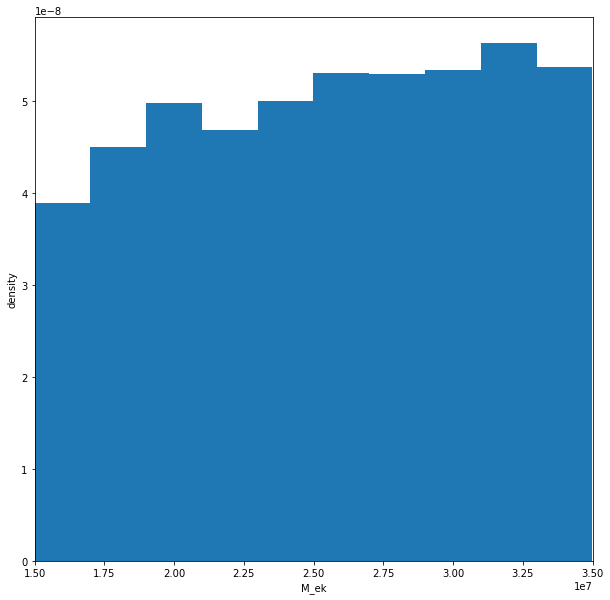

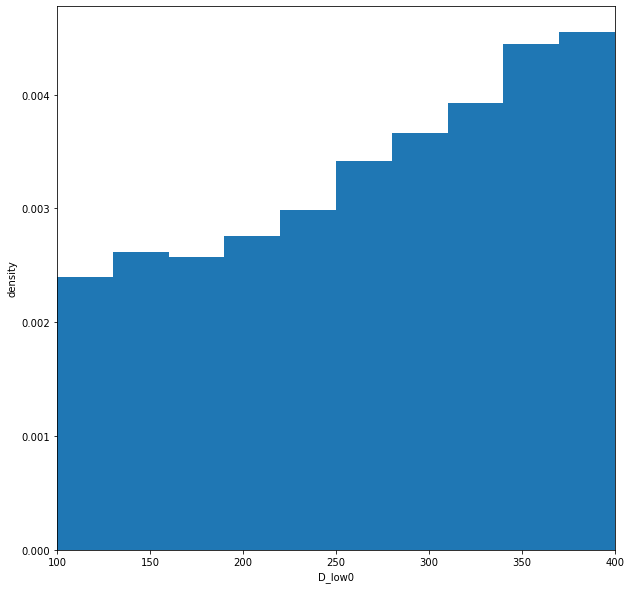

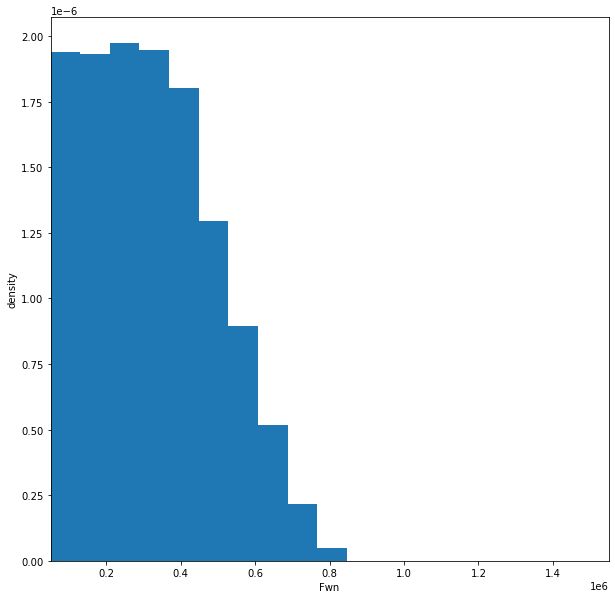

In [67]:
# Plot real non-shutoffs
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

real_non_shutoff_idxs = np.where(gan_trainer.real_labels == 0)[0]
x_seeds_agg = gan_trainer.real_dataset[real_non_shutoff_idxs, :]

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'real_nonshutoffs_{f_var}_hist.jpeg')
    ax.hist(x_seeds_agg[:, f_idx], density=True)
    ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_xlabel(f_var)
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

In [68]:
# # Plot real recoveries
# perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
#                                       gan_trainer.ic_param_scaler.data_max_)]

# real_recovery_idxs = np.where(gan_trainer.real_labels == 2)[0]
# x_seeds_agg = gan_trainer.real_dataset[real_recovery_idxs, :]

# for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
#     fig, ax = plt.subplots(figsize=(10, 10))
#     hist_save_path = os.path.join(save_dir, save_subdir, f'real_recoveries_{f_var}_hist.jpeg')
#     ax.hist(x_seeds_agg[:, f_idx], density=True)
#     ax.set_xlim(perturb_feats_lims[f_idx])
#     ax.set_xlabel(f_var)
#     ax.set_ylabel("density")
#     plt.savefig(hist_save_path)

## Generated

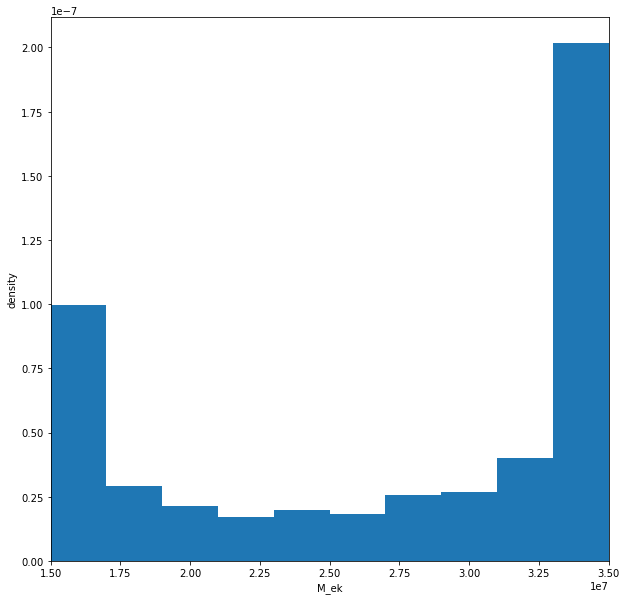

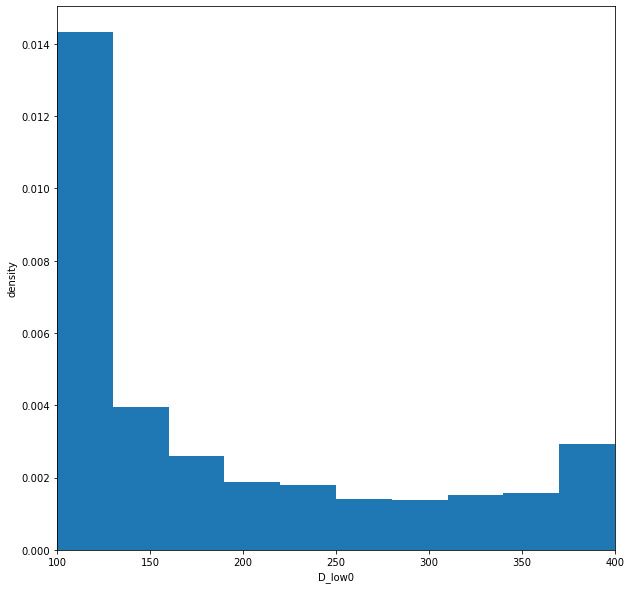

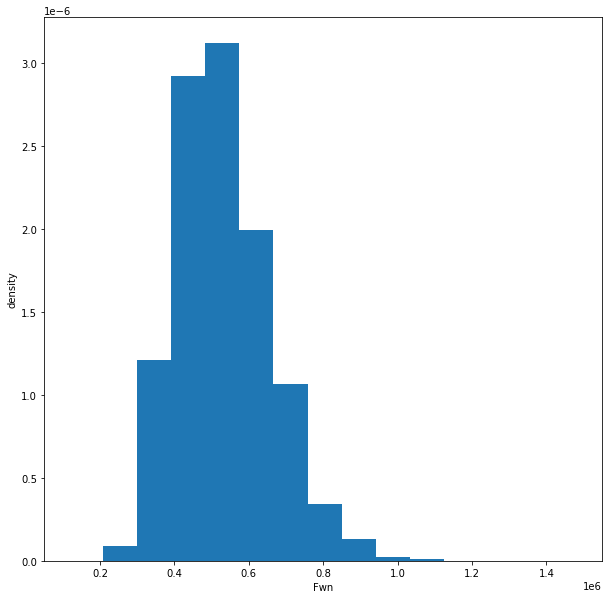

In [69]:
# Plot all generated solutions
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

# Aggregate seeds
x_seeds_agg = np.stack(gen_shutoff_cfgs + \
    gen_non_shutoff_cfgs +
    gen_recovery_cfgs, axis=0)

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'gen_configs_{f_var}_hist.jpeg')
    ax.hist(x_seeds_agg[:, f_idx], density=True)
    ax.set_xlabel(f_var)

    # Set x_lim
    if x_seeds_agg[:, f_idx].max() - x_seeds_agg[:, f_idx].min() > 1.0:
        ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

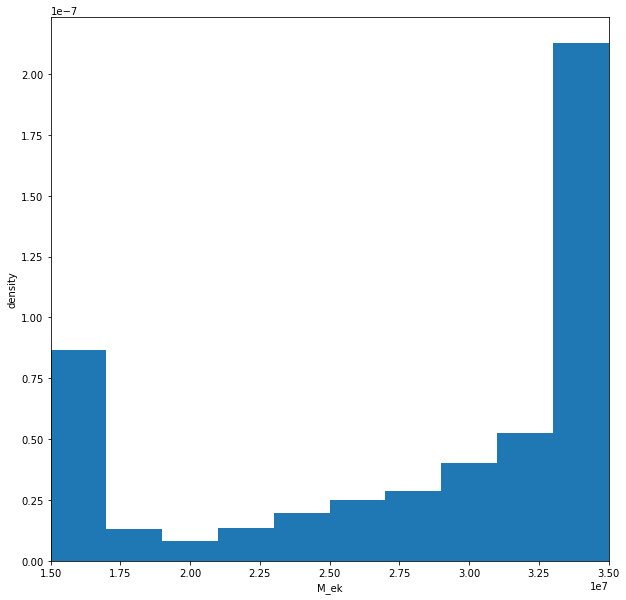

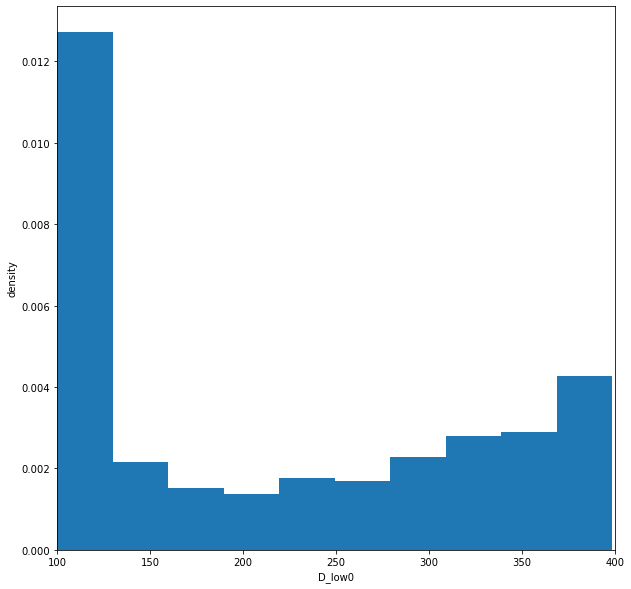

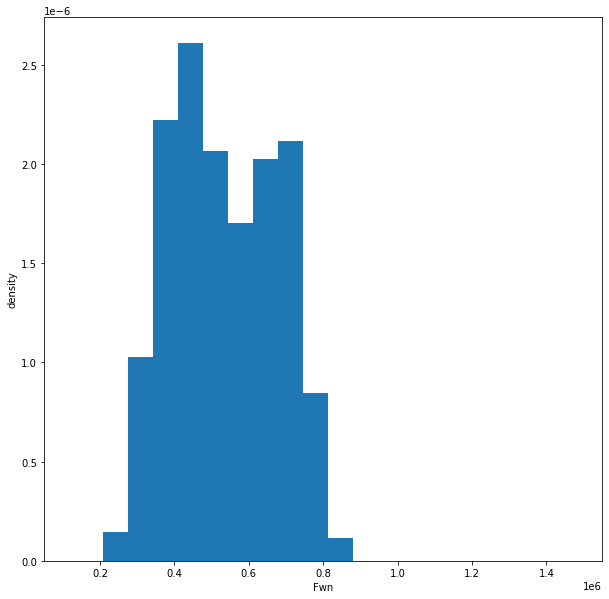

In [70]:
# Plot distribution of non-shutoffs
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

# Aggregate seeds
x_seeds_agg = np.stack(gen_non_shutoff_cfgs, axis=0)
# x_seeds_agg = np.concatenate(gen_non_shutoff_cfgs, axis=0)

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'gen_nonshutoff_configs_{f_var}_hist.jpeg')
    ax.hist(x_seeds_agg[:, f_idx], density=True)
    ax.set_xlabel(f_var)

    # Set x_lim
    if x_seeds_agg[:, f_idx].max() - x_seeds_agg[:, f_idx].min() > 1.0:
        ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

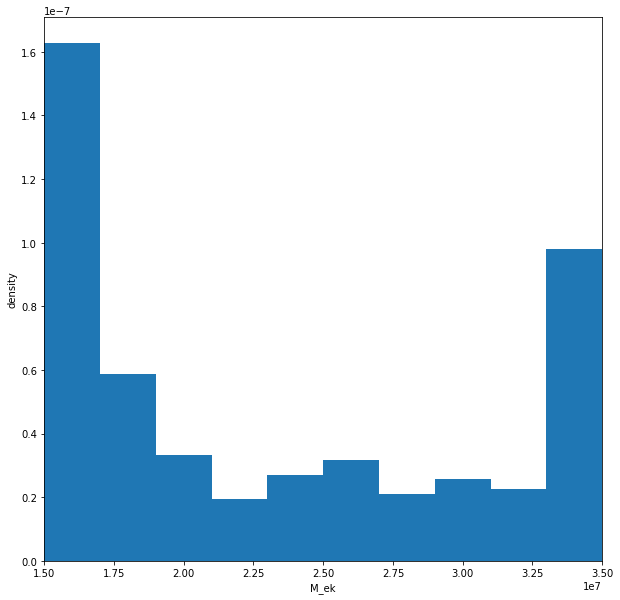

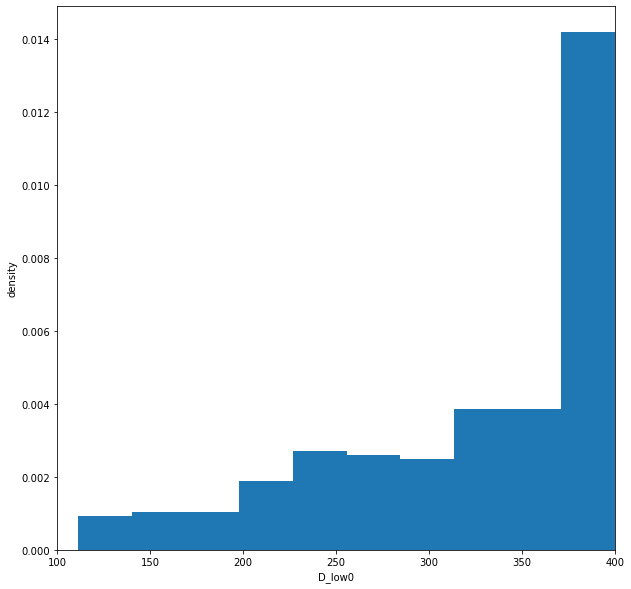

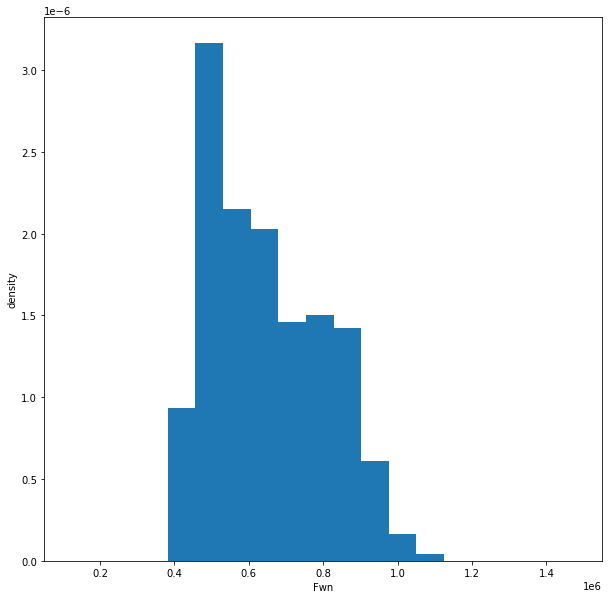

In [71]:
# Plot distribution of aggregated gen_seeds
perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
                                      gan_trainer.ic_param_scaler.data_max_)]

# Aggregate seeds
x_seeds_agg = np.stack(gen_shutoff_cfgs, axis=0)
# x_seeds_agg = np.concatenate(x_seeds, axis=0)

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
    fig, ax = plt.subplots(figsize=(10, 10))
    hist_save_path = os.path.join(save_dir, save_subdir, f'gen_shutoff_configs_{f_var}_hist.jpeg')
    ax.hist(x_seeds_agg[:, f_idx], density=True)
    ax.set_xlabel(f_var)

    # Set x_lim
    if x_seeds_agg[:, f_idx].max() - x_seeds_agg[:, f_idx].min() > 1.0:
        ax.set_xlim(perturb_feats_lims[f_idx])
    ax.set_ylabel("density")
    plt.savefig(hist_save_path)

In [72]:
# # Plot distribution of aggregated gen_seeds
# perturb_feats_lims = [(x,y) for x,y in zip(gan_trainer.ic_param_scaler.data_min_,
#                                       gan_trainer.ic_param_scaler.data_max_)]

# # Aggregate seeds
# x_seeds_agg = np.stack(gen_recovery_cfgs, axis=0)
# # x_seeds_agg = np.concatenate(x_seeds, axis=0)

# for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
#     fig, ax = plt.subplots(figsize=(10, 10))
#     hist_save_path = os.path.join(save_dir, save_subdir, f'gen_recovery_configs_{f_var}_hist.jpeg')
#     ax.hist(x_seeds_agg[:, f_idx], density=True)
#     ax.set_xlabel(f_var)

#     # Set x_lim
#     if x_seeds_agg[:, f_idx].max() - x_seeds_agg[:, f_idx].min() > 1.0:
#         ax.set_xlim(perturb_feats_lims[f_idx])
#     ax.set_ylabel("density")
#     plt.savefig(hist_save_path)

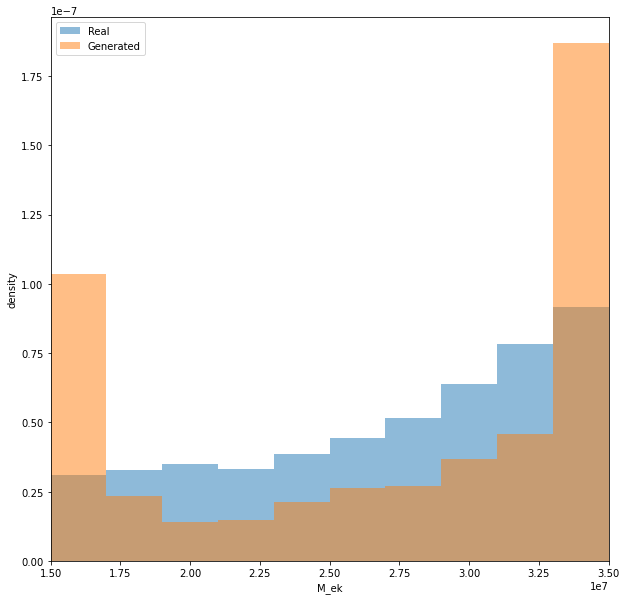

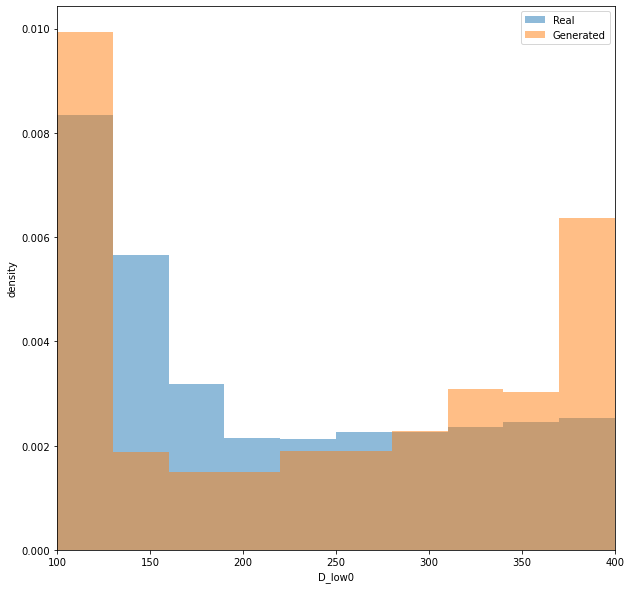

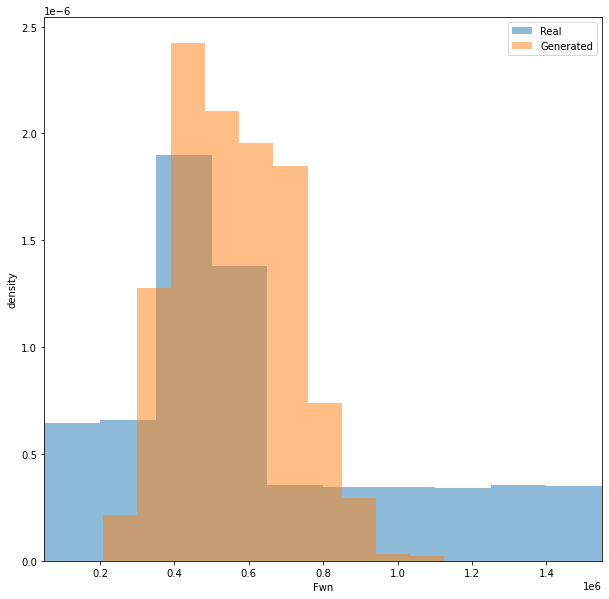

In [73]:
# Histogram w/ real and generated configs
real_configs = gan_trainer.real_dataset
gen_configs = np.concatenate((gen_shutoff_cfgs, gen_non_shutoff_cfgs), axis=0)

for f_idx, f_var in enumerate(surrogate_model.perturb_vars):
	fig, ax = plt.subplots(figsize=(10, 10))
	hist_save_path = os.path.join(save_dir, save_subdir, f'real_vs_gen_{f_var}_hist.jpeg')
	# Plot real/gen configs
	ax.hist(real_configs[:, f_idx], density=True, alpha=0.5)
	ax.hist(gen_configs[:, f_idx], density=True, alpha=0.5)
	ax.set_xlabel(f_var)

	# Set x_lim
	if x_seeds_agg[:, f_idx].max() - x_seeds_agg[:, f_idx].min() > 1.0:
		ax.set_xlim(perturb_feats_lims[f_idx])
	ax.set_ylabel("density")

	# Make legend
	ax.legend(["Real", "Generated"])
	plt.savefig(hist_save_path)

## Create data file

In [ ]:
# data_dict = {}
# n = len(gen_shutoff_cfgs) + len(gen_non_shutoff_cfgs)
# for box_arg in surrogate_model.args_order:
# 	if box_arg in surrogate_model.constants_dict:
# 		data_dict[box_arg] = np.ones(n)*surrogate_model.constants_dict[box_arg]
# 	else:
# 		arg_idx = surrogate_model.perturb_vars.index(box_arg)
# 		data_dict[box_arg] = np.stack([x[arg_idx] for x in gen_shutoff_cfgs + gen_non_shutoff_cfgs], axis=0)

# # Labels
# data_dict["label"] = np.concatenate((np.ones(len(gen_shutoff_cfgs)), np.zeros(len(gen_non_shutoff_cfgs))), axis=0)

In [ ]:
# # pkl file
# pkl_file = os.path.join(save_dir, save_subdir, f'gen_anand_sim{sim_idx}_chkpt{chkpt_idx}_data.pkl')
# with open(pkl_file, "wb") as f:
# 	pickle.dump(data_dict, f, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# # csv file
# data_df = pd.DataFrame(data_dict)
# csv_file = pkl_file = os.path.join(save_dir, save_subdir, f'gen_anand_sim{sim_idx}_chkpt{chkpt_idx}_data.csv')
# data_df.to_csv(csv_file, index=False)

# Discriminator Metrics

In [ ]:
def evaluate_configs(gan_trainer, cfgs, b_sz=128):
	# Set discriminator in evaluation mode
	gan_trainer.disc.eval()
	i = 0
	b_sz = 128
	mad_logits, clf_logits = [], []
	with torch.inference_mode():
		while i < cfgs.shape[0]:
			x_norm = cfgs[i:i+b_sz].to(gan_trainer.device)
			# x_clf_logits = gan_trainer.disc(x_norm)
			x_mad_logits, x_clf_logits = gan_trainer.disc(x_norm)
			mad_logits.append(x_mad_logits)
			clf_logits.append(x_clf_logits)

			i += b_sz

	mad_logits = torch.cat(mad_logits, dim=0)
	clf_logits = torch.cat(clf_logits, dim=0)

	# return clf_logits
	return mad_logits, clf_logits

# todo: make compute metrics function later
# Set up train/test set normalized tensors for prediction
train_dataset_norm = gan_trainer.ic_param_scaler.transform(gan_trainer.train_dataset)
train_seeds = torch.from_numpy(train_dataset_norm).double().to(gan_trainer.device)

test_dataset_norm = gan_trainer.ic_param_scaler.transform(gan_trainer.test_dataset)
test_seeds = torch.from_numpy(test_dataset_norm).double().to(gan_trainer.device)

# Make predictions
# train_clf_logits = evaluate_configs(gan_trainer, train_seeds, b_sz=128)
# test_clf_logits = evaluate_configs(gan_trainer, test_seeds, b_sz=128)
train_mad_logits, train_clf_logits = evaluate_configs(gan_trainer, train_seeds, b_sz=128)
test_mad_logits, test_clf_logits = evaluate_configs(gan_trainer, test_seeds, b_sz=128)

print("########## TRAINING SET METRICS ###########")
train_mad_preds = torch.argmax(train_mad_logits, axis=1).cpu().numpy()
train_clf_preds = torch.argmax(train_clf_logits, axis=1).cpu().numpy()

# Compute clf metrics
train_clf_prec = precision_score(gan_trainer.train_labels, train_clf_preds, average=None)
train_clf_recall = recall_score(gan_trainer.train_labels, train_clf_preds, average=None)
train_clf_f1 = f1_score(gan_trainer.train_labels, train_clf_preds, average=None)

for i,cn in enumerate(class_names):
	print(f"CLASS: {cn}")
	print(f"{cn} examples: {(gan_trainer.train_labels == i).sum()}")
	print(f"Clf precision: {train_clf_prec[i]:.3f}",)
	print(f"Clf recall: {train_clf_recall[i]:.3f}")
	print(f"Clf F1: {train_clf_f1[i]:.3f}")
	print()

# Compute MAD-GAN metrics
# train_mad_prec = precision_score(np.ones_like(train_mad_preds), train_mad_preds)
# train_mad_recall = recall_score(np.ones_like(train_mad_preds), train_mad_preds)
# train_mad_f1 = f1_score(np.ones_like(train_mad_preds), train_mad_preds)

# print(f"MAD-GAN precision: {train_mad_prec:.3f}")
# print(f"MAD-GAN recall: {train_mad_recall:.3f}")
# print(f"MAD-GAN F1: {train_mad_f1:.3f}")
# train_mad_conf_mat = confusion_matrix(gan_trainer.n_gens*np.ones_like(train_mad_preds), train_mad_preds)
print("##################################")
print()

print("########## TEST SET METRICS ###########")
test_mad_preds = torch.argmax(test_mad_logits, axis=1).cpu().numpy()
test_clf_preds = torch.argmax(test_clf_logits, axis=1).cpu().numpy()

# Compute clf metrics
test_clf_prec = precision_score(gan_trainer.test_labels, test_clf_preds, average=None)
test_clf_recall = recall_score(gan_trainer.test_labels, test_clf_preds, average=None)
test_clf_f1 = f1_score(gan_trainer.test_labels, test_clf_preds, average=None)

for i,cn in enumerate(class_names):
	print(f"CLASS: {cn}")
	print(f"{cn} examples: {(gan_trainer.test_labels == i).sum()}")
	print(f"Clf precision: {test_clf_prec[i]:.3f}",)
	print(f"Clf recall: {test_clf_recall[i]:.3f}")
	print(f"Clf F1: {test_clf_f1[i]:.3f}")
	print()

# Compute MAD-GAN metrics
# test_mad_prec = precision_score(np.ones_like(test_mad_preds), test_mad_preds)
# test_mad_recall = recall_score(np.ones_like(test_mad_preds), test_mad_preds)
# test_mad_f1 = f1_score(np.ones_like(test_mad_preds), test_mad_preds)

# print(f"MAD-GAN precision: {test_mad_prec:.3f}")
# print(f"MAD-GAN recall: {test_mad_recall:.3f}")
# print(f"MAD-GAN F1: {test_mad_f1:.3f}")
# test_mad_conf_mat = confusion_matrix(gan_trainer.n_gens*np.ones_like(test_mad_preds), test_mad_preds)
print("##################################")

########## TRAINING SET METRICS ###########
CLASS: Non-shutoff
Non-shutoff examples: 5363
Clf precision: 0.995
Clf recall: 0.998
Clf F1: 0.996

CLASS: Shutoff
Shutoff examples: 5411
Clf precision: 0.998
Clf recall: 0.995
Clf F1: 0.996

##################################

########## TEST SET METRICS ###########
CLASS: Non-shutoff
Non-shutoff examples: 1371
Clf precision: 0.995
Clf recall: 0.995
Clf F1: 0.995

CLASS: Shutoff
Shutoff examples: 1323
Clf precision: 0.995
Clf recall: 0.995
Clf F1: 0.995

##################################


In [ ]:
# Concatenate discriminator predictions and labels
disc_mad_preds = np.concatenate((train_mad_preds, test_mad_preds))
disc_mad_labels = gan_trainer.n_gens*np.ones_like(disc_mad_preds)

disc_clf_preds = np.concatenate((train_clf_preds, test_clf_preds))
disc_clf_labels = np.concatenate((gan_trainer.train_labels, gan_trainer.test_labels))

In [ ]:

# Evaluate against generator dataset
gen_mad_logits, gen_clf_logits = evaluate_configs(gan_trainer, torch.Tensor(gen_cfgs_scaled).double(), b_sz=128)
gen_mad_preds = torch.argmax(gen_mad_logits, axis=1).cpu().numpy()
gen_clf_preds = torch.argmax(gen_clf_logits, axis=1).cpu().numpy()
gen_clf_labels = np.concatenate((np.ones(len(gen_shutoff_cfgs)),
	np.zeros(len(gen_non_shutoff_cfgs)),
	2*np.ones(len(gen_recovery_cfgs))),
	axis=0)

# Make labels
print("Getting labels...")
# Compute generator metrics
# gen_clf_labels = gan_trainer.compute_state_changes(gen_cfgs, return_tensors=False)
gen_clf_prec = precision_score(gen_clf_labels, gen_clf_preds, average=None)
gen_clf_recall = recall_score(gen_clf_labels, gen_clf_preds, average=None)
gen_clf_f1 = f1_score(gen_clf_labels, gen_clf_preds, average=None)
gen_clf_labels = np.array(gen_clf_labels)

for i,cn in enumerate(class_names):
	print(f"CLASS: {cn}")
	print(f"{cn} examples: {(gen_clf_labels == i).sum()}")
	c_gen_prec, c_gen_recall, c_gen_f1 = gen_clf_prec[i], gen_clf_recall[i], gen_clf_f1[i]
	print(f"Clf precision: {c_gen_prec:.3f}",)
	print(f"Clf recall: {c_gen_recall:.3f}")
	print(f"Clf F1: {c_gen_f1:.3f}")
	print()

# Append to disc_preds, disc_labels
disc_mad_preds = np.concatenate((disc_mad_preds, gen_mad_preds))
disc_mad_labels = np.concatenate((disc_mad_labels, n_gens*np.ones_like(gen_mad_preds))) # todo: these labels are not correct - 

disc_clf_preds = np.concatenate((disc_clf_preds, gen_clf_preds))
disc_clf_labels = np.concatenate((disc_clf_labels, gen_clf_labels))

Getting labels...
CLASS: Non-shutoff
Non-shutoff examples: 874
Clf precision: 0.698
Clf recall: 0.830
Clf F1: 0.758

CLASS: Shutoff
Shutoff examples: 1820
Clf precision: 0.910
Clf recall: 0.827
Clf F1: 0.867



########### Plotting clf confusion matrix...#####################


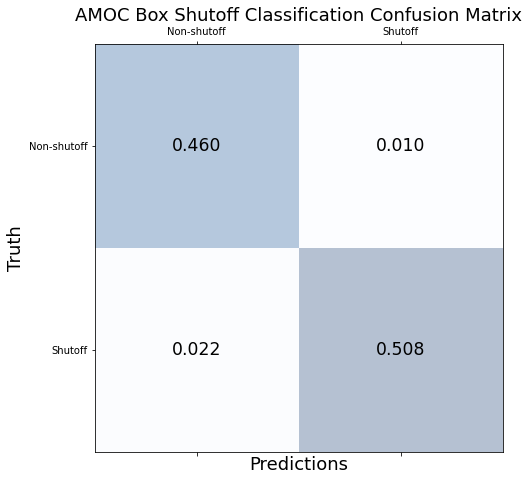

In [ ]:
def make_confusion_matrix(labels: np.ndarray, preds: np.ndarray, classes: list[str], save_file: str):
    conf_mat = confusion_matrix(labels, preds, normalize="all")
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
    ax.set_xticks(np.arange(len(classes)), classes)
    ax.set_yticks(np.arange(len(classes)), classes)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=j, y=i,s=f"{conf_mat[i, j]:.3f}", va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Truth', fontsize=18)
    plt.title('AMOC Box Shutoff Classification Confusion Matrix', fontsize=18)

    plt.savefig(save_file, bbox_inches='tight')
    plt.show()
# todo: should modify these plots
# todo: look at confusion matrices for train set, test set, generated sets separately
# print("########### Plotting MAD confusion matrix...#####################")
# mad_conf_mat = confusion_matrix(disc_mad_labels, disc_mad_preds, normalize="all")
# fig, ax = plt.subplots(figsize=(7.5, 7.5))
# ax.matshow(mad_conf_mat, cmap=plt.cm.Blues, alpha=0.3)
# ax.set_xticks(np.arange(gan_trainer.n_gens+1), [f"Gen {i}" for i in range(gan_trainer.n_gens)] + ["Real"])
# ax.set_yticks(np.arange(gan_trainer.n_gens+1), [f"Gen {i}" for i in range(gan_trainer.n_gens)] + ["Real"])
# for i in range(mad_conf_mat.shape[0]):
#     for j in range(mad_conf_mat.shape[1]):
#         ax.text(x=j, y=i,s=f"{mad_conf_mat[i, j]:.2f}", va='center', ha='center', size='xx-large')

# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Truth', fontsize=18)
# plt.title('MAD Confusion Matrix', fontsize=18)

# mad_conf_filename = os.path.join(save_dir, save_subdir, f'mad_confusion_matrix_{chkpt_idx}.jpeg')
# plt.savefig(mad_conf_filename, bbox_inches='tight')
# plt.show()

print("########### Plotting clf confusion matrix...#####################")
clf_conf_mat = confusion_matrix(disc_clf_labels, disc_clf_preds, normalize="all")
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(clf_conf_mat, cmap=plt.cm.Blues, alpha=0.3)
if n_classes == 2:
    ax.set_xticks(np.arange(2), ["Non-shutoff", "Shutoff"])
    ax.set_yticks(np.arange(2), ["Non-shutoff", "Shutoff"])
elif n_classes == 3:
    ax.set_xticks(np.arange(3), ["Non-shutoff", "Shutoff", "Recovery"])
    ax.set_yticks(np.arange(3), ["Non-shutoff", "Shutoff", "Recovery"])    
for i in range(clf_conf_mat.shape[0]):
    for j in range(clf_conf_mat.shape[1]):
        ax.text(x=j, y=i,s=f"{clf_conf_mat[i, j]:.3f}", va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Truth', fontsize=18)
plt.title('AMOC Box Shutoff Classification Confusion Matrix', fontsize=18)

clf_conf_filename = os.path.join(save_dir, save_subdir, f'clf_confusion_matrix_{chkpt_idx}.jpeg')
plt.savefig(clf_conf_filename, bbox_inches='tight')
plt.show()

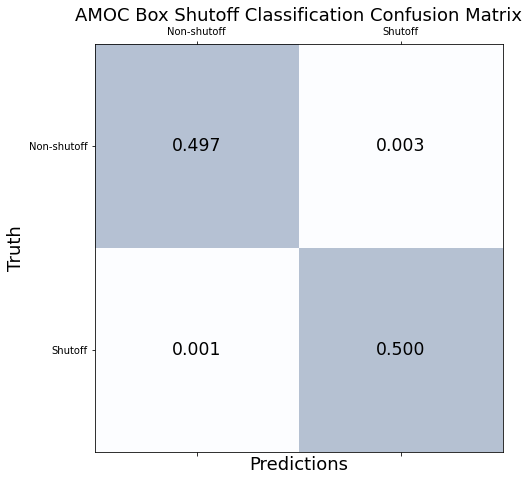

In [ ]:
classes = ["Non-shutoff", "Shutoff"]
conf_mat_save_file = os.path.join(save_dir, save_subdir, f'train_clf_confusion_matrix_{chkpt_idx}.jpeg')
make_confusion_matrix(train_clf_preds, gan_trainer.train_labels, classes=classes, save_file=conf_mat_save_file)

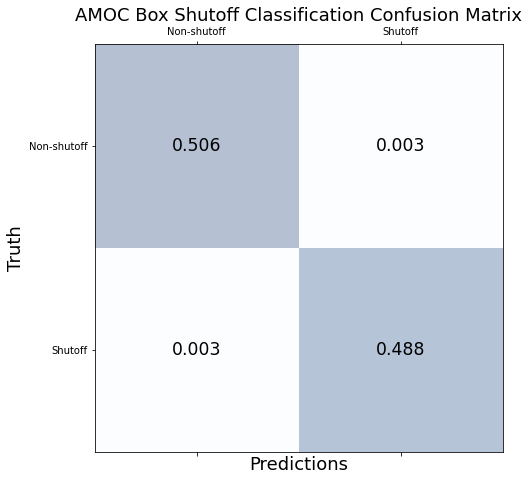

In [ ]:
conf_mat_save_file = os.path.join(save_dir, save_subdir, f'test_clf_confusion_matrix_{chkpt_idx}.jpeg')
make_confusion_matrix(test_clf_preds, gan_trainer.test_labels, classes=classes, save_file=conf_mat_save_file)

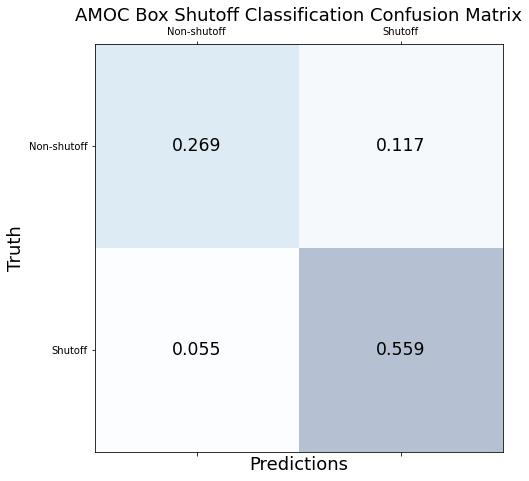

In [ ]:
conf_mat_save_file = os.path.join(save_dir, save_subdir, f'gen_clf_confusion_matrix_{chkpt_idx}.jpeg')
make_confusion_matrix(gen_clf_preds, gen_clf_labels, classes=classes, save_file=conf_mat_save_file)